In [1]:
import os; os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urbanstats.games.quiz_analysis import get_full_statistics, questions
from urbanstats.games.quiz import (
    display_question,
    stats_to_display,
    renamed,
    get_statistic_categories,
    compute_difficulty,
    ranges,
)

/home/kavi/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
text_to_col = {q : k for k, q in stats_to_display.items()}
text_to_col.update(renamed)

In [5]:
 plt.rcParams["font.family"] = "monospace"

In [6]:
result = get_full_statistics(after_problem=1, debug=False)
num_users_by_problem = result.groupby("problem").count().user_id
means = result[["problem", "score", *questions]].groupby("problem").mean()

/home/kavi/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:1309: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  keys, values, mutated = self.grouper.apply(f, data, self.axis)


In [7]:
qdata = []
for problem in means.index:
    with open(f"/home/kavi/temp/site/quiz/{problem}") as f:
        quiz_qns = json.load(f)
    for qcol, q in zip(questions, quiz_qns):
        qn = q["question"]
        if "dewpoint" in qn or "hawaiian" in qn or "native" in qn.lower() or "area" in qn:
            continue
        sl, sh = q["stat_a"], q["stat_b"]
        if sl > sh:
            sh, sl = sl, sh
        if qn not in text_to_col:
            print(qn)
            continue
        qdata.append(dict(
            a=q["longname_a"],
            b=q["longname_b"],
            ease=means.loc[problem, qcol],
            col=text_to_col[qn],
            stat_high=sh,
            stat_low=sl
        ))

/home/kavi/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


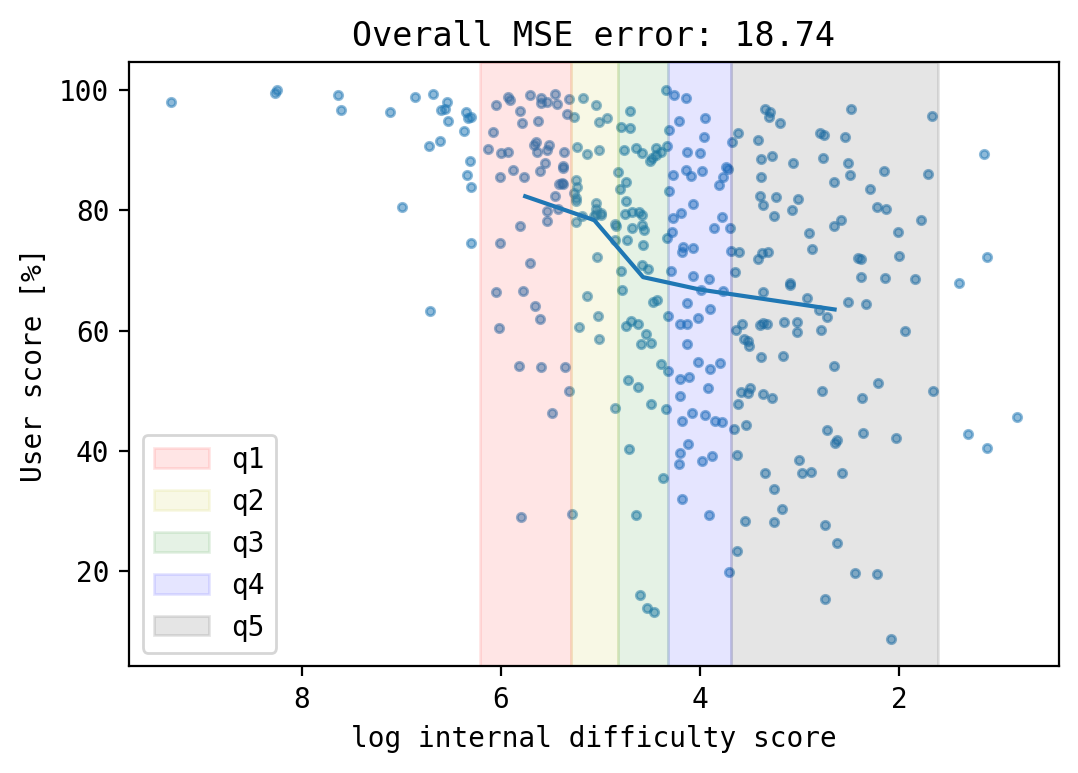

In [8]:
qdata = pd.DataFrame(qdata)
qdata["log_diff"] = np.log(qdata.stat_high / qdata.stat_low)
qdata["pct_diff"] = qdata.stat_high / qdata.stat_low - 1
qdata["cat"] = qdata.col.apply(lambda x: get_statistic_categories()[x])
qdata["diffi"] = qdata.apply(lambda row: compute_difficulty(row.stat_high, row.stat_low, row.col), axis=1)

plt.figure(dpi=200, facecolor="white")
x, y = np.log(qdata.diffi), qdata.ease * 100
bucket_loc = []
ease_each = []
delta = []
err_total = 0
qdata["delta"] = np.nan
rs = [list(x) for x in ranges]
# rs[0][-1] = 10000
# rs[-1][0] = 1
for i, (lo, hi) in enumerate(rs):
    mask = (np.log(lo) < x) & (x <= np.log(hi))
    ease_each.append(y[mask].mean())
    bucket_loc.append((np.log(lo) + np.log(hi)) / 2)
    delta.append(y[mask] - ease_each[-1])
    qdata.loc[mask, "delta"] = delta[-1]
    err_total += (delta[-1] ** 2).sum()
    plt.axvspan(np.log(lo), np.log(hi), alpha=0.1, color="rygbk"[i], label=f"q{i+1}")
err_total = (err_total / y.shape[0]) ** 0.5
plt.scatter(x, y, alpha=0.5, marker=".")
plt.plot(bucket_loc, ease_each)
#     plt.plot(xs, ys)
plt.xlabel("log internal difficulty score")
plt.xlim(plt.xlim()[::-1])
plt.ylabel("User score [%]")
plt.title(f"Overall MSE error: {err_total:.2f}")
plt.legend()
plt.show()

In [9]:
u = qdata[qdata.delta == qdata.delta].groupby("cat").mean().sort_values("delta")["delta"]
for i in u.index:
    print(i, u[i])

race -4.038090298218281
transportation -1.545566592847341
weather -1.5360171959823752
feature -1.4966253665164166
election -0.19880726384177233
national_origin 0.2532709383024327
income 0.3459370915175331
housing 0.9027183379159031
misc 0.9269533780005588
generation 1.284388832498658
education 1.9544885081271417
main 5.369742004282725


In [10]:
qdata[qdata.diffi > ranges[0][-1]]

,a,b,ease,col,stat_high,stat_low,log_diff,pct_diff,cat,diffi,delta
4,"Wyoming, USA","District of Columbia, USA",1.000000,ad_1,6.569571e+03,6.239748e+02,2.354094,9.528584,main,3811.433653,NaN
7,"St. Louis city-County, Missouri, USA","Loudoun County, Virginia, USA",0.859259,asian,2.122959e-01,4.047046e-02,1.657409,4.245701,race,566.093484,NaN
13,"Ponce MSA, PR, USA","Montgomery MSA, AL, USA",0.805755,household_income_over_100k,2.416347e-01,3.197919e-02,2.022342,6.555998,income,1092.666314,NaN
36,"Oklahoma, USA","Hawaii, USA",0.968504,rent_1br_over_1500,3.829024e-01,3.288008e-02,2.454913,10.645421,housing,709.694750,NaN
43,"Laredo [Urban Area], TX, USA","Dallas-Fort Worth-Arlington [Urban Area], TX, USA",0.966942,asian,8.218561e-02,5.122046e-03,2.775426,15.045464,race,2006.061844,NaN
48,"Wilmington MSA, NC, USA","Chicago-Naperville-Elgin MSA, IL-IN-WI, USA",0.963768,asian,7.052923e-02,1.327060e-02,1.670476,4.314699,race,575.293154,NaN
57,"Cleveland city, Ohio, USA","Houston city, Texas, USA",0.991379,population,2.305349e+06,3.724060e+05,1.823003,5.190419,main,2076.167409,NaN
68,"San Luis Obispo-Paso Robles-Arroyo Grande MSA,...","Tulsa MSA, OK, USA",0.838926,black,7.779335e-02,1.533156e-02,1.624143,4.074067,race,543.208903,NaN
71,"Oklahoma, USA","New Jersey, USA",0.988166,transportation_means_transit,9.758486e-02,3.271681e-03,3.395418,28.827129,transportation,960.904303,NaN
74,"Boulder MSA, CO, USA","Tallahassee MSA, FL, USA",0.881356,rent_2br_over_1500,6.738289e-01,7.295728e-02,2.223102,8.235937,housing,549.062451,NaN


In [11]:
qdata[qdata.diffi < ranges[-1][0]]

,a,b,ease,col,stat_high,stat_low,log_diff,pct_diff,cat,diffi,delta
30,"Austin [Urban Area], TX, USA","Allentown-Bethlehem [Urban Area], PA-NJ, USA",0.427350,transportation_means_car,0.855045,0.769188,0.105819,0.111621,transportation,3.720694,NaN
80,"Vermont, USA","Illinois, USA",0.456311,insurance_coverage_private,0.738698,0.706554,0.044489,0.045493,misc,2.274671,NaN
86,"Pennsylvania, USA","Texas, USA",0.405000,housing_per_pop,0.553602,0.529374,0.044751,0.045767,housing,3.051142,NaN
177,"Jacksonville FL Media Market, USA","Dothan AL Media Market, USA",0.722603,transportation_means_car,0.940035,0.861313,0.087459,0.091397,transportation,3.046574,NaN
199,"Greensboro city, North Carolina, USA","Long Beach city, California, USA",0.678788,transportation_means_walk,0.025173,0.022454,0.114307,0.121096,transportation,4.036533,NaN
237,"Lafayette LA Media Market, USA","Minot-Bismarck-Dickinson ND Media Market, USA",0.894133,language_english_only,0.944600,0.901838,0.046327,0.047417,national_origin,3.161103,NaN
